In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,ConfusionMatrixDisplay,auc, roc_curve
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [73]:
np.random.seed(42)

In [74]:
DATA_FOLDER = '../data/advertising.csv'

data = pd.read_csv(DATA_FOLDER)

In [117]:
data.sample(3)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
440,46.04,32,65499.93,147.92,Universal transitional Graphical User Interface,Andrewborough,0,Serbia,2016-05-30 20:07:59,1
512,84.53,33,61922.06,215.18,Optional multi-state hardware,Douglasview,1,Norfolk Island,2016-07-11 09:32:53,0
943,39.30,32,48335.20,145.73,Decentralized bottom-line help-desk,Jonathanland,0,Lithuania,2016-02-24 04:11:37,1


In [94]:
X = data.drop(columns=['Clicked on Ad', 'Timestamp'])
y = data['Clicked on Ad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Creating functions for Precison, recall, confusion matrix, ROC AUC curves and feature importances

In [92]:
def accuracy_metrics(model):
    
    y_pred = model.predict(X_test)
    
    print("Accuracy is", accuracy_score(y_test, y_pred))
    print("Precision is", precision_score(y_pred, y_test))
    print("Recall is", recall_score(y_test, y_pred))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
    disp.plot(cmap='Blues')

In [107]:
def roc_auc(model):
    # Check if the model supports `predict_proba`
    if hasattr(model, "predict_proba"):
        # Use probabilities for the positive class
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        # Use decision scores for models like SVC
        y_prob = model.decision_function(X_test)
    else:
        raise ValueError("The provided model does not support predict_proba or decision_function.")
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc_score = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


In [108]:
def feature_imp(model, model_step_name):

    rf_model = model.named_steps[model_step_name]

    importances = rf_model.feature_importances_
    feature_names = X_train.columns

    feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
    plt.title('Feature Importances from Random Forest', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.show()

## Creating the pipeline

In [76]:
trf1 = ColumnTransformer([
    ('ordinal_encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),[4, 5, 7])
], remainder='passthrough')
# [4, 5, 7] are the categorical columns --> Ad Topic Line, City, Country 

In [77]:
trf2 = ColumnTransformer([
    ('scaling', MinMaxScaler(), slice(0, 8))
])

In [78]:
trf3 = RandomForestClassifier()

In [79]:
pipe = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2),
    ('trf3', trf3)
])

## Cross Validation with Random Forest and finding the best hyperparameters

In [81]:
param_grid = {
    'trf3__n_estimators': [20, 50, 100, 200, 500],
    'trf3__max_depth': [None, 10, 20, 30, 50],
    'trf3__min_samples_split': [2, 5, 10],
    'trf3__min_samples_leaf' : [1,2,4,8],
    'trf3__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
Best parameters: {'trf3__max_depth': None, 'trf3__max_features': 'sqrt', 'trf3__min_samples_leaf': 1, 'trf3__min_samples_split': 2, 'trf3__n_estimators': 50}
Best cross-validation accuracy: 0.9724999999999999


c:\Users\Venkat\Ad_click_prediction\env\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [82]:
best_model_rf = grid_search.best_estimator_
y_pred = best_model_rf.predict(X_test)

accuracy_score(y_test, y_pred)

0.93

Accuracy is 0.93
Precision is 0.9459459459459459
Recall is 0.9459459459459459
Confusion Matrix:
[[ 81   8]
 [  6 105]]


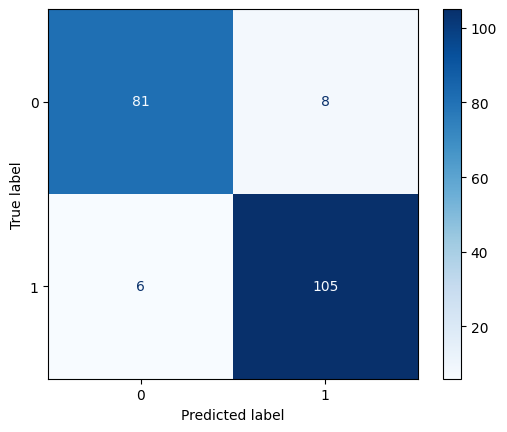

In [96]:
accuracy_metrics(best_model_rf)

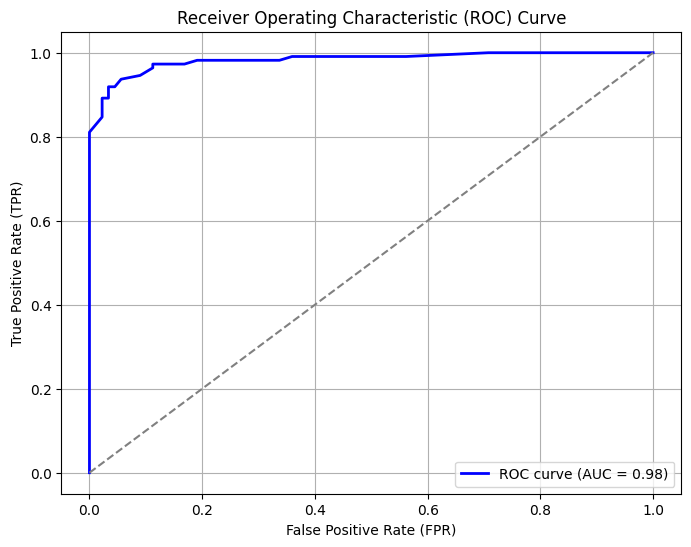

In [109]:
roc_auc(best_model_rf)

C:\Users\Venkat\AppData\Local\Temp\ipykernel_23240\412830617.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')


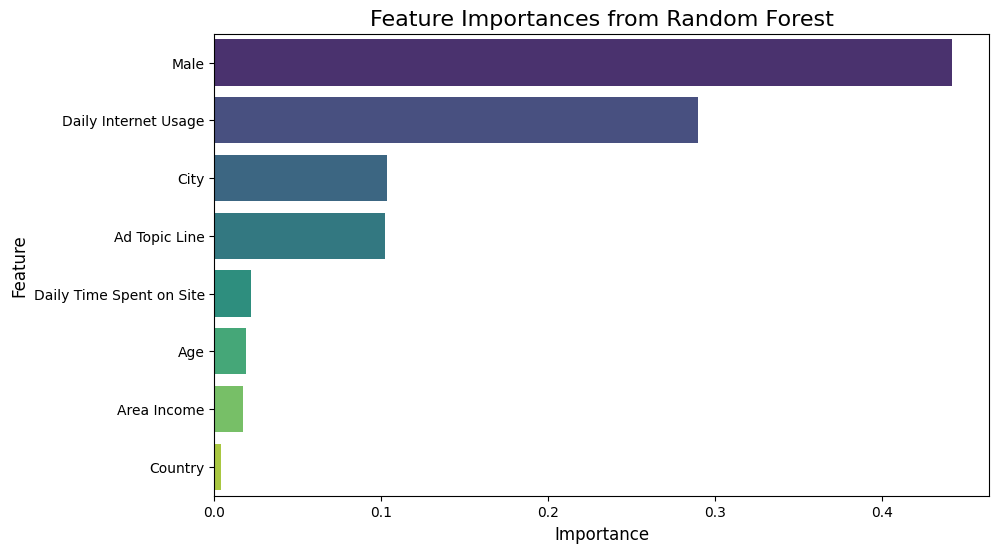

In [110]:
feature_imp(best_model_rf, 'trf3')

## Cross Validation with Gradient Boosting and finding the best hyperparameters

In [100]:
trf4 = GradientBoostingClassifier()

In [84]:
pipe_1 = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2),
    ('trf4', trf4)
])

In [85]:
param_grid = {
    'trf4__n_estimators': [50, 100, 200],             
    'trf4__learning_rate': [0.01, 0.1, 0.2],         
    'trf4__max_depth': [3, 5, 7],           
    'trf4__min_samples_split': [2, 5, 10],      
    'trf4__min_samples_leaf': [1, 2, 4],                         
}

grid_search = GridSearchCV(estimator=pipe_1, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)


grid_search.fit(X_train, y_train)

print("Best parameters for Gradient Boosting:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\Venkat\Ad_click_prediction\env\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for Gradient Boosting: {'trf4__learning_rate': 0.1, 'trf4__max_depth': 7, 'trf4__min_samples_leaf': 2, 'trf4__min_samples_split': 5, 'trf4__n_estimators': 100}
Best cross-validation accuracy: 0.9650000000000001


In [86]:
best_model_gb = grid_search.best_estimator_
y_pred = best_model_gb.predict(X_test)

accuracy_score(y_test, y_pred)

0.925

Accuracy is 0.925
Precision is 0.9279279279279279
Recall is 0.9279279279279279
Confusion Matrix:
[[ 82   7]
 [  8 103]]


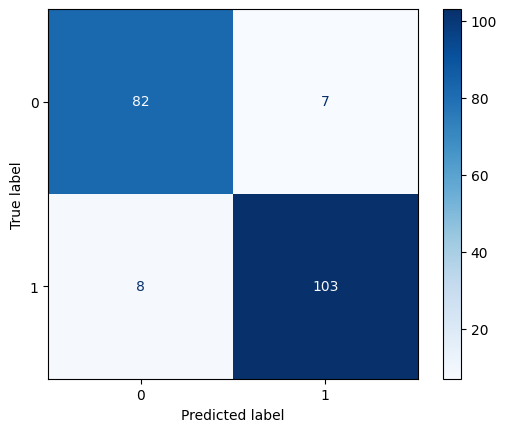

In [101]:
accuracy_metrics(best_model_gb)

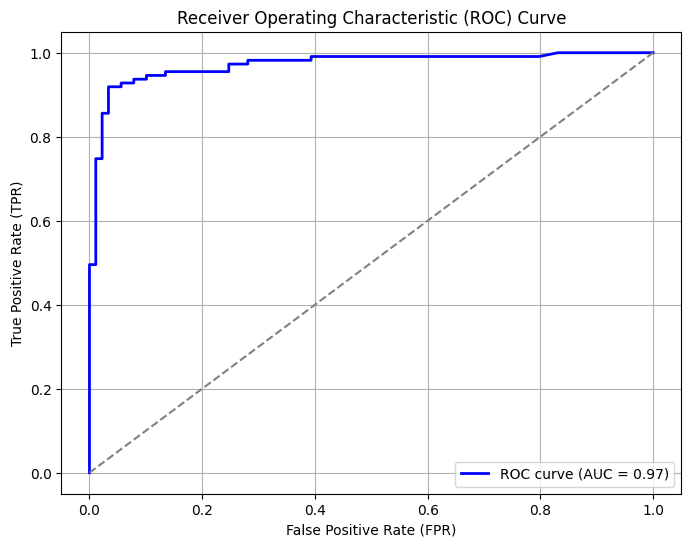

In [111]:
roc_auc(best_model_gb)

C:\Users\Venkat\AppData\Local\Temp\ipykernel_23240\412830617.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')


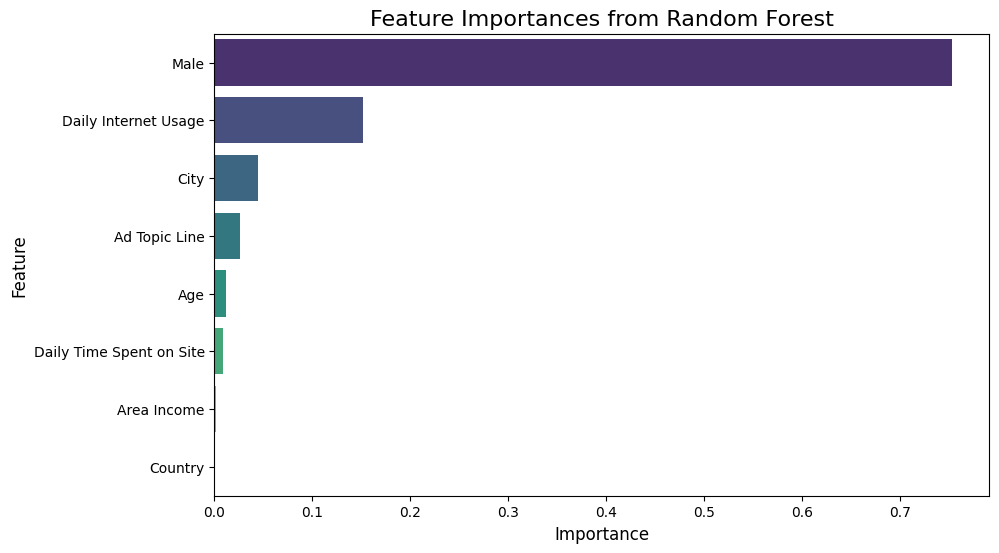

In [104]:
feature_imp(best_model_gb, 'trf4')

## Cross Validation with Support Vector Classifier and finding the best hyperparameters

In [87]:
trf5 = SVC()

In [88]:
pipe_2 = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2),
    ('trf5', trf5)
])

In [89]:
param_grid = {
    'trf5__C': [0.1, 1, 10, 100],               
    'trf5__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
    'trf5__degree': [2, 3, 4],                  
    'trf5__gamma': ['scale', 'auto', 0.001, 0.01],  
    'trf5__coef0': [0.0, 0.1, 0.5]             
}

grid_search = GridSearchCV(estimator=pipe_2, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)


grid_search.fit(X_train, y_train)

print("Best parameters for Gradient Boosting:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters for Gradient Boosting: {'trf5__C': 100, 'trf5__coef0': 0.1, 'trf5__degree': 2, 'trf5__gamma': 'auto', 'trf5__kernel': 'poly'}
Best cross-validation accuracy: 0.9775


In [90]:
best_model_svc = grid_search.best_estimator_
y_pred = best_model_svc.predict(X_test)

accuracy_score(y_test, y_pred)

0.95

Accuracy is 0.95
Precision is 0.9459459459459459
Recall is 0.9459459459459459
Confusion Matrix:
[[ 85   4]
 [  6 105]]


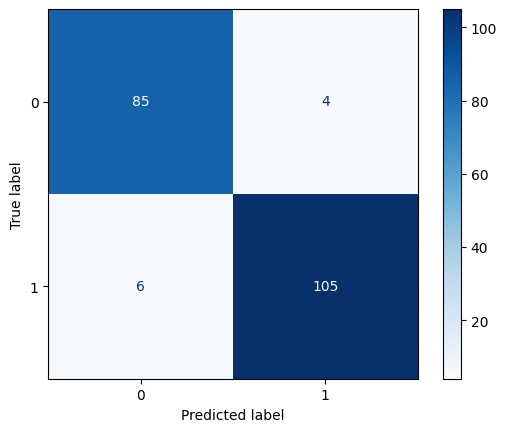

In [105]:
accuracy_metrics(best_model_svc)

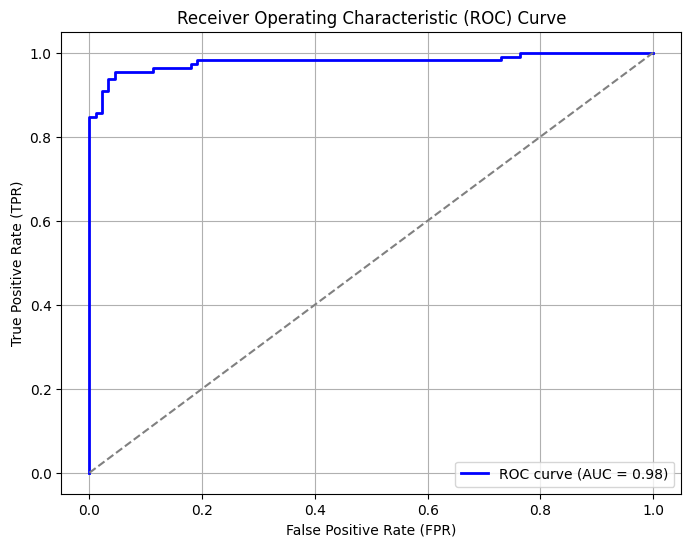

In [112]:
roc_auc(best_model_svc)

In [119]:
with open('../models/final.pkl', 'wb') as f:
    pickle.dump(best_model_svc, f)